# Lab 02_2: Transmon Qubit - Grounded Type

### developed by Seong Hyeon Park (pajoheji0909@snu.ac.kr)

### Please find the attached homework at the end of this tutorial code

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from qiskit_metal import designs, MetalGUI, Dict

design = designs.DesignPlanar()
design.overwrite_enabled = True

In [ ]:
# set the overall layout size (X)
design.chips.main.size.size_x = '3mm'
# set the overall layout size (Y)
design.chips.main.size.size_y = '3mm'
# set the substrate thickness (Z)
design.chips.main.size.size_z = '-400um'

## start GUI of Qiskit-Metal and ANSYS HFSS

In [ ]:
# start GUI
gui = MetalGUI(design)

In [ ]:
hfss = design.renderers.hfss
# start ANSYS HFSS
hfss.start()

In [ ]:
import pyEPR as epr
import qiskit_metal as metal

# set custom substrate materials

In [ ]:
newMaterial_name = 'silicon_custom'
newMaterial_permittivity = '11.45'
newMaterial_losstangent = '1e-9'

from pyEPR import ansys, project_info
ans_prj = project_info.ProjectInfo()
oProject = ans_prj.project._project
defmanager = oProject.GetDefinitionManager()

if not defmanager.DoesMaterialExist(newMaterial_name):
    defmanager.AddMaterial(
        [
            "NAME:%s"%(newMaterial_name),
            "CoordinateSystemType:=", "Cartesian",
            "BulkOrSurfaceType:=", 1,
            [
                    "NAME:PhysicsTypes",
                    "set:=", ["Electromagnetic"]
            ],
            "permittivity:=", "%s"%(newMaterial_permittivity),
            "dielectric_loss_tangent:=", "%s"%(newMaterial_losstangent)
        ])

ans_prj.project.release()
ans_prj.desktop.release()
ans_prj.app.release()
ansys.release()

design.chips['main']['material'] = newMaterial_name

# design your qubits!

In [ ]:
# there are various in-built qubit types in Qiskit-Metal, you should try it by yourself
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

In [ ]:
# everytime you need to redefine the component, you should delete the misdefined components
design.delete_all_components()

## Custom options for all the transmons
options = dict(
    # see default options and available options!
    cross_width = '30 um', 
    cross_length = '220 um',
    cross_gap = '20 um',
    # connector
    connection_pads=dict(
        readout = dict(connector_type='0',  # 0 = Claw type, 1 = gap type
            claw_length='100um',
            ground_spacing='5um',
            claw_width='20um',
            claw_gap='6um',
            claw_cpw_length='40um',
            claw_cpw_width='10um',
            connector_location= '90'  # 0 => 'west' arm, 90 => 'north' arm, 180 => 'east' arm)
        )
    )
)

## Create a double pad transmon
q1 = TransmonCross(design, 'Q1', options = dict(pos_x='0 mm', pos_y='0 mm', **options))

# rebuild the GUI (if not, you can't see the components)
gui.rebuild()

# auto-rescale the GUI
gui.autoscale()

# take a screenshot of the GUI
gui.screenshot()

# Energy Participation Ratio (EPR)

Based on the canonical quantization of an arbitrary electrical circuit (ZK Minev *et al.*, "Energy-participation quantization of Josephson circuits," *npj Quantum Inf.,* **7**, 131 (2021) DOI: https://doi.org/10.1038/s41534-021-00461-8), we can extract the qubit parameters from eigenmode FEM simulations.

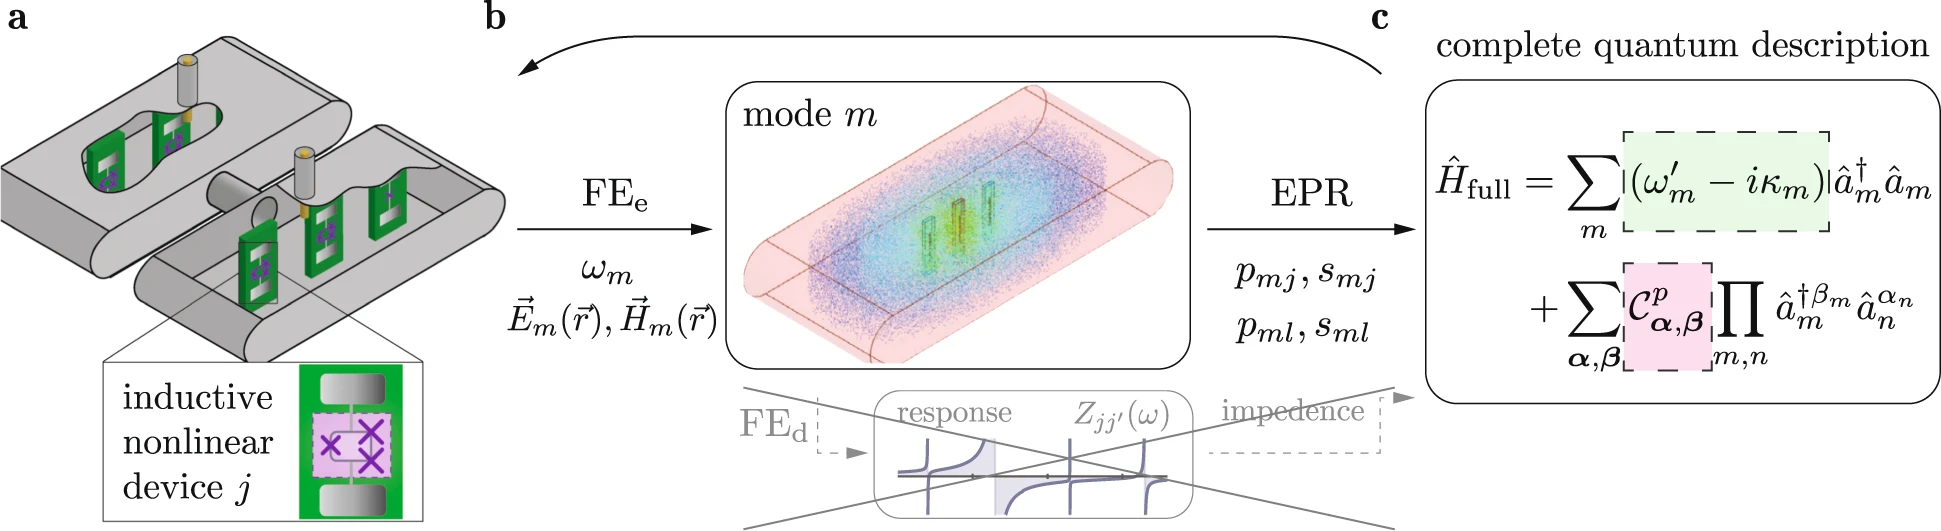

In [ ]:
from qiskit_metal.analyses.quantization import EPRanalysis

# project name
proj_name = "lab02_grounded_transmon"

eig_s = EPRanalysis(design, "hfss")
hfss = eig_s.sim.renderer

try:
    hfss.start()
except:
    hfss.activate_design(proj_name)

Identify the non-linear (Josephson) junctions in the model. You will need to list the junctions in the epr setup.

In this case there's only one junction, namely 'jj'. Let's see what we need to change in the default setup.

The name of the `Lj_variable` and `Cj_variable` match with our model. However it is missing the names of the shapes that identify the junction (`rect` and `line`). Look for those in the renderer and find the name. Then let's change the name (See below).

In [ ]:
from qiskit_metal.analyses.quantization import EPRanalysis

# define the EPR analysis class
eig_s = EPRanalysis(design, "hfss")

# define the renderer program for the eigenmode simulation
hfss = eig_s.sim.renderer

# try-except to avoid common(?) error during the HFSS rendering
try:
    hfss.start()
except:
    hfss.activate_design(proj_name)

# NOTE: you should define the junction in HFSS
eig_s.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_s.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'

# define the setup
em_s = eig_s.sim.setup
em_s.name = "setup_custom"

# minimum searching frequency
em_s.min_freq_ghz = 3

# target eigenmode number
em_s.n_modes = 1

# maximum pass number
em_s.max_passes = 15

# criteria for eigenmode simulation convergence: maximum delta F_eigen between passes < value
em_s.max_delta_f = 0.5

# simulation minimum converged passes 
em_s.min_converged = 2

# simulation order 0: point, 1: line, 2: face
em_s.basis_order = 1

# Design variables can also be added in for direct simulation sweeps. Here, we have to set the junction inductance and capacitance
em_s.vars = Dict({'Lj': '12 nH', 'Cj': '2 fF'})


In [ ]:
eig_s.sim._render(name=proj_name,                         # design name
                  selection = [],                         # if None --> all
                  solution_type='eigenmode',              # NOTE: case sensitive
                  vars_to_initialize=em_s.vars,           # set variables
                  open_pins=[('Q1', 'readout')],          # set open pins
                  port_list=[],                           # set ports, for eigenmode simulations --> R = 50 Ohm boundary conditions 
                  box_plus_buffer = False)                # if False --> set the overall layout as you defined above. If True --> set marginal chip sizes as you set here.

## set mesh configurations

In [ ]:
# mesh setting name, components, maximum mesh length
hfss.modeler.mesh_length('qubitpad_mesh_setting', ['cross_Q1', 'readout_connector_arm_Q1'], MaxLength='0.02 mm')

## start eigenmode simulation

In [ ]:
eig_s.sim._analyze()

## validate the project information

In [ ]:
pinfo = hfss.pinfo
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj', 'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied

## DO EPR analysis! (perturbation theory)

In [ ]:
eprd = epr.DistributedAnalysis(pinfo)
eprd.do_EPR_analysis()

## Do EPR analysis! (numerical diagonalization of the Hamiltonian)

#### NOTE: `cos_trunc`: truncated order for a cosine potential of a Josephson junction and `Fock_trunc`: truncated order for an oscillator   
#### NOTE: `PT`: Perturbation theory and `ND`: Numerical diagonalization

In [ ]:
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 10)

# LAB HOMEWORK

### Transmon qubit (floating type; double pad geometry) simulations. You should achieve the target parameters within 3\%. The overall circuit layout, electric field distribution, and the convergence plot vs. adaptive pass should be attached to the report.

1. Analyze the variations of qubit frequency by increasing (or decreasing) `cross_width`, `cross_length` and `cross_gap` of a double pad geometry. You should analyze the qubit frequency with `LOM` and `EPR` methods.
2. Design a double pad qubit to have $\omega_q/2\pi=4.5$ GHz with `cross_width=30 µm`, `cross_length=220 µm` and `cross_gap=20 µm` from the `LOM` method. You may change the Junction inductance $L_J$ of a qubit.

### Now, we will reproduce some results (Table I) in R Barends *et al.,* "Coherent Josephson Qubit Suitable for Scalable Quantum Integrated Circuits," *Phys. Rev. Lett.,* **111**, 080502 (2013).
#### DOI: https://doi.org/10.1103/PhysRevLett.111.080502 or arXiv: https://arxiv.org/abs/1304.2322

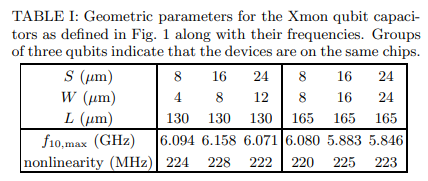

3. Modify the substrate material into `sapphire` with a dielectric constant of `10`. Then, reproduce the qubit geometries and parameters in Fig. 1 and Table I (NOTE: `cross_length` in our code is NOT identical to the $L$ in Table I. You have to try all 6 types of Xmon qubits in Table I.)